In [ ]:
import numbers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy
from scipy.integrate import odeint
import deeptime as dtime
import sklearn
from sklearn.cluster import MiniBatchKMeans, KMeans

colors_state_ = plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('font', size=14)

# 0. Define functions: 

In [2]:
def time_delay_embedding(data: np.ndarray, delay: int) -> np.ndarray:
    """Create a time-delay embedding of a N times D numpy data array.

    Args:
        data (np.ndarray): The input data array of shape (N, D).
        delay (int): The time delay (lag) for creating the embedding.

    Returns:
        np.ndarray: The time-delay embedded data array of shape (N - delay, D * (delay + 1)).
    """

    # Check if the input data is a numpy array
    if not isinstance(data, np.ndarray):
        raise TypeError("Input data must be a numpy array")

    # Check if delay is a non-negative integer
    if not isinstance(delay, numbers.Integral) or delay < 0:
        raise ValueError("Delay must be a non-negative integer")

    # Create the time-delay embedding
    embedded_data = np.hstack([np.roll(data, i, axis=0) for i in range(delay + 1)])

    # Remove the rows with NaN values introduced by rolling
    embedded_data = embedded_data[delay:]

    return embedded_data


def cluster_data(data: np.ndarray, n_clusters: int, algorithm: str = 'kmeans',
                 random_state: int or None = None,
                 batch_size: int or None = None) -> tuple:
    """
    Perform clustering on the input data using either KMeans or MiniBatchKMeans.

    Args:
        data (np.ndarray): The input data array of shape (N, D).
        n_clusters (int): The number of clusters to form.
        algorithm (str): The clustering algorithm to use, either 'kmeans' or 'minibatchkmeans' (default: 'kmeans').
        random_state (int or None): The random seed for reproducibility (default: None).
        batch_size (int or None): The number of samples to use for each mini-batch (only applicable for 'minibatchkmeans').

    Returns:
        tuple: A tuple containing:
        np.ndarray: The transformed discrete time series.
        np.ndarray: The cluster centers.
        model: The kmeans model. 
    """

    # Perform clustering based on the selected algorithm
    if algorithm == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=3)
    elif algorithm == 'minibatchkmeans':
        if batch_size is None:
            batch_size = 3 * n_clusters
        model = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state,
                                batch_size=batch_size, n_init=3)
    else:
        raise ValueError(
            "Invalid algorithm. Choose either 'kmeans' or 'minibatchkmeans'")

    # Fit the model and get cluster assignments and centers
    cluster_assignments = model.fit_predict(data)
    cluster_centers = model.cluster_centers_

    return cluster_assignments, cluster_centers, model


def compare_time_series(data1: np.ndarray, data2: np.ndarray, k: int,
                        label1: str = 'Data 1', label2: str = 'Data 2'):
    """
    Compare the first K dimensions of two multi-dimensional time series on the same subplot.

    Parameters:
    - data1: 2D array-like, shape (N, D)
      The first multi-dimensional time series data.
    - data2: 2D array-like, shape (N, D)
      The second multi-dimensional time series data.
    - k: int
      The number of dimensions to compare.
    - label1: str, optional (default='Data 1')
      Label for the first data source.
    - label2: str, optional (default='Data 2')
      Label for the second data source.
    """

    N, D = data1.shape
    time_steps = np.arange(N)

    # Create subplots for each selected dimension
    fig, axes = plt.subplots(k, 1, figsize=(10, 2 * k), sharex=True)

    for i in range(min(k, D)):
        axes[i].plot(time_steps, data1[:, i], label=label1)
        axes[i].plot(time_steps, data2[:, i], label=label2)
        axes[i].set_ylabel(f'Dimension {i + 1}')

    plt.xlabel('Time Steps')
    plt.suptitle(f'Comparison of First {k} Dimensions of Time Series')

    # Show legend only once
    axes[0].legend()

    plt.show()

# 1. Create data: 

In [3]:
def Lorenz(state, t, sigma, rho, beta):
    # unpack the state vector
    x, y, z = state
    # compute state derivatives
    xd = sigma * (y - x)
    yd = (rho - z) * x - y
    zd = x * y - beta * z
    # return the state derivatives
    return [xd, yd, zd]


dt = 0.02
frameRate = 1 / dt
T = 2000
# T = 500
discard_T = 100
T_total = T + discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total * frameRate))
sigma, rho, beta = 10, 28, 8 / 3
tseries = np.array(odeint(Lorenz, state0, t, args=(sigma, rho, beta)),
                   dtype=np.float64)[int(discard_T / dt):]
print(f"{tseries.shape=}")

tseries.shape=(100000, 3)


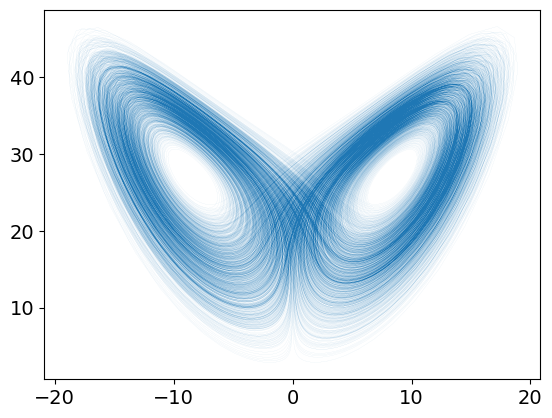

In [4]:
# Plot
plt.plot(tseries[:, 0], tseries[:, 2], lw=.02)
plt.show()

In [5]:
# raw data to use:
X = tseries[:, 0].reshape((tseries.shape[0], 1))  #take x variable only
print(f"{X.shape=}")

X.shape=(100000, 1)


# 2. Create sample transition matrix

#### 2.1 Timedelay-embedding + clustering

In [6]:
delay = 5
n_clusters = 200

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="minibatchkmeans")
print(f"{labels.shape=}")
print(f"{centers.shape=}")

traj_matrix.shape=(99995, 6)
labels.shape=(99995,)
centers.shape=(200, 6)


traj_matrix_reconstructed.shape=(99995, 6)


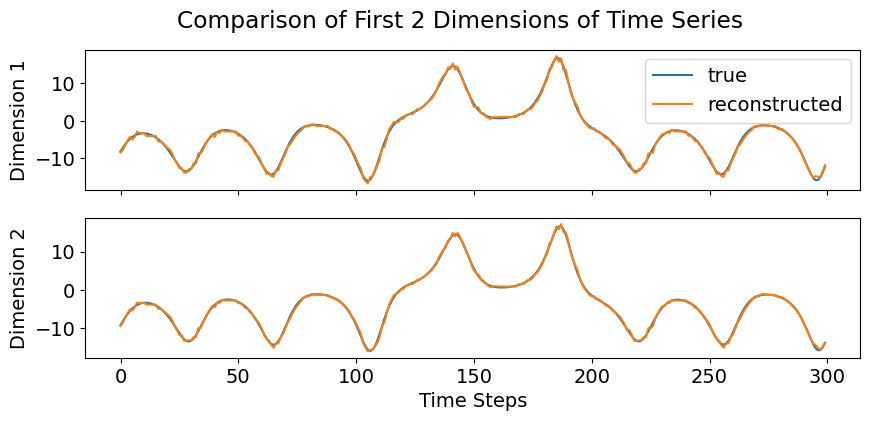

In [7]:
# reconstruct timeseries: 
traj_matrix_reconstructed = centers[labels, :]
print(f"{traj_matrix_reconstructed.shape=}")

# plot reconstruction: 
compare_time_series(traj_matrix[:300, :], traj_matrix_reconstructed[:300, :], k=2,
                    label1="true", label2="reconstructed")

#### 2.2 Create transition matrix with deeptime: 

Text(0, 0.5, 'states')

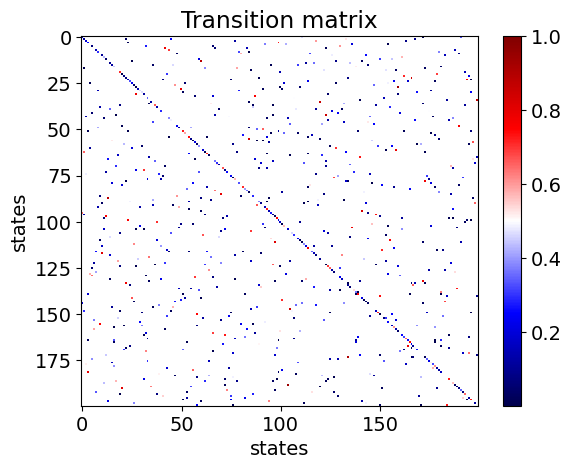

In [8]:
lag = 1

# count matrix: 
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=True)

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title("Transition matrix")
plt.xlabel("states")
plt.ylabel("states")

#### 2.3 Sample Markov model

In [9]:
msm = dtime.markov.msm.MarkovStateModel(P)

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")

n_steps = 1000
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_real_space = centers[simulated_labels]
print(f"{simulated_real_space.shape=}")

start_state_real_space.shape=(1, 6)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_real_space.shape=(1000, 6)


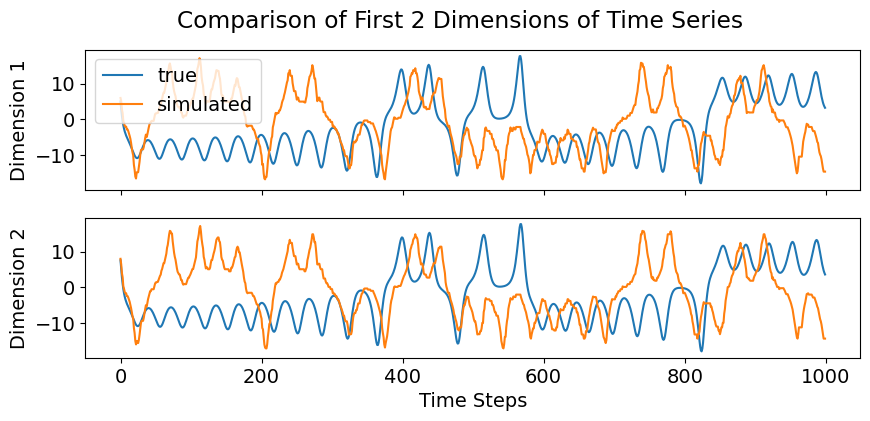

In [10]:
# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_real_space[:time_window, :], k=2, label1="true",
                    label2="simulated")

# 3. Minimize entropy of transition matrix

#### 3.1 Define entropy function as a function of the transition matrix: 

In [11]:
def get_entropy(transition_matrix: scipy.sparse.csr_matrix) -> float:
    """
    Calculate the entropy of a Markov chain represented by a transition matrix.

    Args:
        transition_matrix (scipy.sparse.csr_matrix): The transition matrix of the Markov chain.

    Returns:
        float: The entropy of the Markov chain.
    """
    # Calculate the stationary distribution
    mu = dtime.markov.tools.analysis.stationary_distribution(transition_matrix)

    # Convert stationary distribution to a sparse diagonal matrix
    mu_as_sparse_matrix = scipy.sparse.diags(mu)

    # Create a copy of the transition matrix and replace non-zero entries with their logarithms
    logTM = transition_matrix.copy()
    logTM.data = np.log(logTM.data)

    # Compute the entropy using the stationary distribution and logarithmic transition matrix
    entropy = -mu_as_sparse_matrix.dot(transition_matrix.multiply(logTM)).sum()
    return entropy

In [12]:
# Calculate entropy of labels: 

get_entropy(transition_matrix=P)

0.9185934302070997

#### 3.2 Calculate entropy depending on delay-embeddig and number of clusters: 

Aim is to fine the optimal delay and number of clusters. 

In [13]:
# Calculate entropy for various delays and number of clusters. 
lag_use = 1

delay_list = np.arange(1, 15, 2, dtype=int)
n_clusters_list = np.array(np.logspace(2, 3, 4), dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
entropy_data = np.zeros((len(delay_list), len(n_clusters_list)))
for i_delay, delay in enumerate(delay_list):
    traj_matrix_use = time_delay_embedding(data=X, delay=delay)
    for i_n_clusters, n_clusters in enumerate(n_clusters_list):
        labels_use, _, _ = cluster_data(data=traj_matrix_use, n_clusters=n_clusters,
                                        random_state=1, algorithm="minibatchkmeans")
        C_use = dtime.markov.tools.estimation.count_matrix(labels_use,
                                                           lag=lag_use,
                                                           sliding=True)

        P_use = dtime.markov.tools.estimation.transition_matrix(C_use, reversible=False)
        entropy = get_entropy(P_use)
        entropy_data[i_delay, i_n_clusters] = entropy
        print(
            f"Computed for {delay} delays and {n_clusters} clusters. entropy={entropy:.3f}")

Computed for 1 delays and 100 clusters. entropy=1.107
Computed for 1 delays and 215 clusters. entropy=1.220
Computed for 1 delays and 464 clusters. entropy=1.242
Computed for 1 delays and 1000 clusters. entropy=1.255
Computed for 3 delays and 100 clusters. entropy=0.897
Computed for 3 delays and 215 clusters. entropy=0.972
Computed for 3 delays and 464 clusters. entropy=0.978
Computed for 3 delays and 1000 clusters. entropy=1.015
Computed for 5 delays and 100 clusters. entropy=0.862
Computed for 5 delays and 215 clusters. entropy=0.936
Computed for 5 delays and 464 clusters. entropy=0.972
Computed for 5 delays and 1000 clusters. entropy=0.965
Computed for 7 delays and 100 clusters. entropy=0.920
Computed for 7 delays and 215 clusters. entropy=0.903
Computed for 7 delays and 464 clusters. entropy=0.948
Computed for 7 delays and 1000 clusters. entropy=0.961
Computed for 9 delays and 100 clusters. entropy=0.918
Computed for 9 delays and 215 clusters. entropy=0.920
Computed for 9 delays an

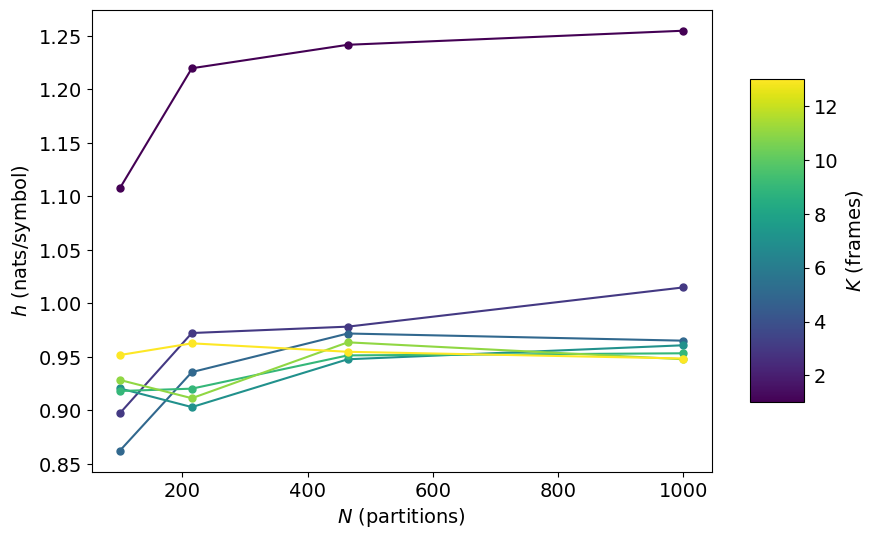

delay_list=array([ 1,  3,  5,  7,  9, 11, 13])
n_clusters_list=array([ 100,  215,  464, 1000])
max_h_K=array([1.25469522, 1.01481211, 0.97173128, 0.96073866, 0.95324344,
       0.96348297, 0.962539  ])


In [14]:
# lot entropy vs n_clusters and delays. 
colors_K = plt.cm.viridis(np.linspace(0, 1, len(delay_list)))
max_h_K = np.zeros(len(delay_list))
cil_h_K = np.zeros(len(delay_list))
ciu_h_K = np.zeros(len(delay_list))
max_idx_array = np.zeros(len(delay_list), dtype=int)
plt.figure(figsize=(10, 6))

for k in range(len(delay_list)):
    plt.errorbar(n_clusters_list, entropy_data[k], c=colors_K[int(k)], capsize=4,
                 marker='o', ms=5)
    max_idx = np.argmax(entropy_data[k])
    max_idx_array[k] = int(max_idx)
    max_h_K[k] = entropy_data[k][max_idx]

plt.scatter(n_clusters_list, entropy_data[k], c=entropy_data[k], vmin=min(delay_list),
            vmax=max(delay_list), s=0)
plt.colorbar(shrink=.7, aspect=6, label='$K$ (frames)')
plt.xlabel('$N$ (partitions)')
plt.ylabel('$h$ (nats/symbol)')
#plt.xscale('log')
plt.show()

print(f"{delay_list=}")
print(f"{n_clusters_list=}")
print(f"{max_h_K=}")

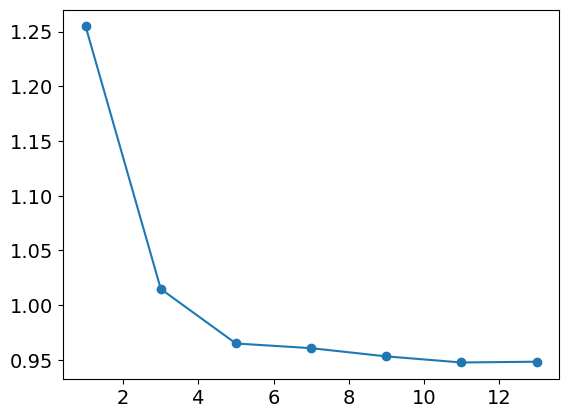

n_cluster = 1000


In [15]:
n_cluster_index = 3
plt.plot(delay_list, entropy_data[:, n_cluster_index], marker='o')
plt.show()
print(f"n_cluster = {n_clusters_list[n_cluster_index]}")

# 4. Analysis of maximally predictive transition matrix

#### 4.1. Calculate the time scales as a function of the lag

In [16]:
delay_star = 11
n_clusters_star = 1000

n_modes = 6

lag_list = np.arange(1, 20, 1)
print(f"{lag_list=}")
time_scales_data = np.zeros((len(lag_list), n_modes))
traj_matrix_star = time_delay_embedding(data=X, delay=delay_star)
labels_star, centers_star, _ = cluster_data(data=traj_matrix_star,
                                            n_clusters=n_clusters_star,
                                            random_state=None,
                                            algorithm="minibatchkmeans")
for i_lag, lag in enumerate(lag_list):

    C_star = dtime.markov.tools.estimation.count_matrix(labels_star,
                                                        lag=lag,
                                                        sliding=True)

    P_star = dtime.markov.tools.estimation.transition_matrix(C_star, reversible=True)
    time_scales = dtime.markov.tools.analysis.timescales(T=P_star,
                                                         tau=lag * dt,
                                                         k=n_modes,
                                                         reversible=False)
    time_scales_data[i_lag, :] = time_scales
    print(f"Computed for {lag=}.")

lag_list=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])
Computed for lag=1.
Computed for lag=2.
Computed for lag=3.
Computed for lag=4.
Computed for lag=5.
Computed for lag=6.
Computed for lag=7.
Computed for lag=8.
Computed for lag=9.
Computed for lag=10.
Computed for lag=11.
Computed for lag=12.
Computed for lag=13.
Computed for lag=14.
Computed for lag=15.
Computed for lag=16.
Computed for lag=17.
Computed for lag=18.
Computed for lag=19.


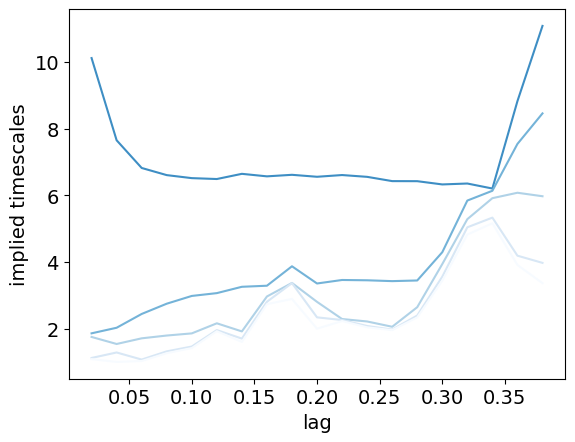

In [17]:
# Plot
colors_modes = plt.cm.Blues_r(np.linspace(0.2, 1, n_modes))
for km in range(1, n_modes):
    plt.plot(lag_list * dt, time_scales_data[:, km], c=colors_modes[km])
plt.xlabel("lag")
plt.ylabel("implied timescales")
plt.show()

#### 4.2. Visualize modes

In [18]:
lag_star = 10
C_star = dtime.markov.tools.estimation.count_matrix(labels_star,
                                                    lag=lag_star,
                                                    sliding=True)
P_star = dtime.markov.tools.estimation.transition_matrix(C_star, reversible=True)
n_modes = 20
eigenvectors = dtime.markov.tools.analysis.eigenvectors(T=P_star, k=n_modes,
                                                        reversible=False)

print(f"{eigenvectors.shape=}")

traj_matrix_pca = sklearn.decomposition.PCA().fit_transform(traj_matrix_star)

eigenvectors.shape=(1000, 20)


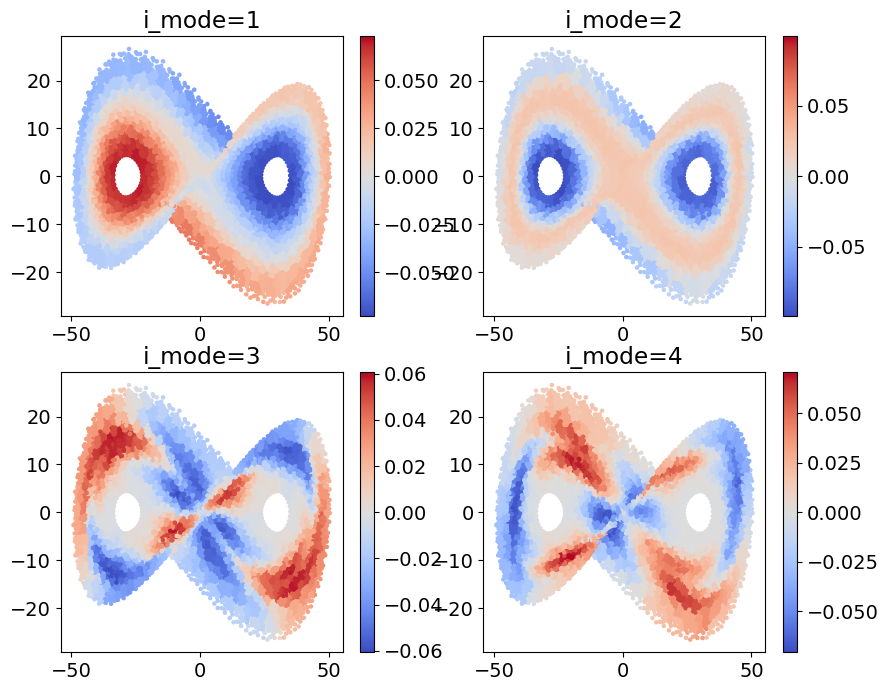

In [19]:
# plot first 4 modes: 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    i_mode = i + 1
    phi2 = eigenvectors[labels_star, i_mode].real
    color_abs = np.max(np.abs(phi2))
    im = ax.scatter(traj_matrix_pca[:, 0], traj_matrix_pca[:, 1], c=phi2,
                    cmap='coolwarm', s=5,
                    vmin=-color_abs, vmax=color_abs)
    ax.set_title(f"{i_mode=}")
    cbar = fig.colorbar(im, ax=ax)
plt.show()

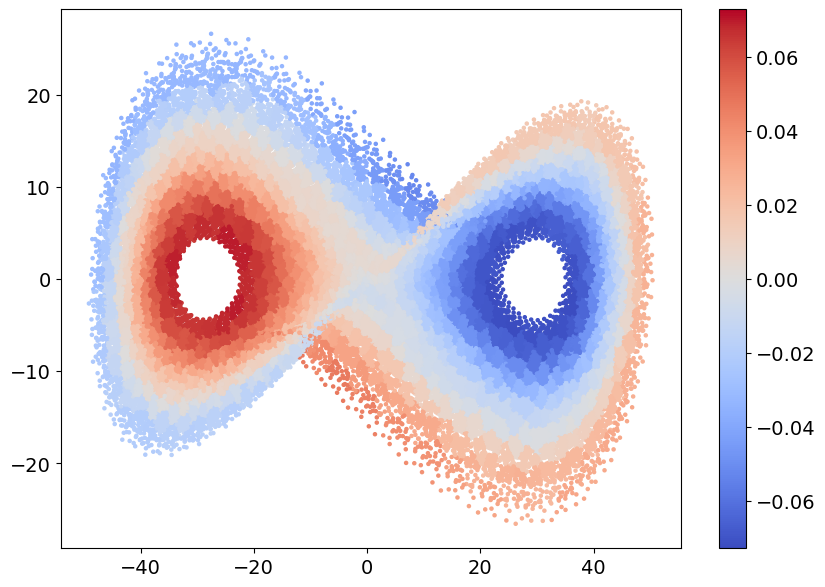

In [20]:
# Plot: 
i_mode = 1

phi2 = eigenvectors[labels_star, i_mode].real
plt.figure(figsize=(10, 7))
color_abs = np.max(np.abs(phi2))
plt.scatter(traj_matrix_pca[:, 0], traj_matrix_pca[:, 1], c=phi2, cmap='coolwarm', s=5,
            vmin=-color_abs, vmax=color_abs)
plt.colorbar()
plt.show()

#### 4.3 Visualize stationary dist

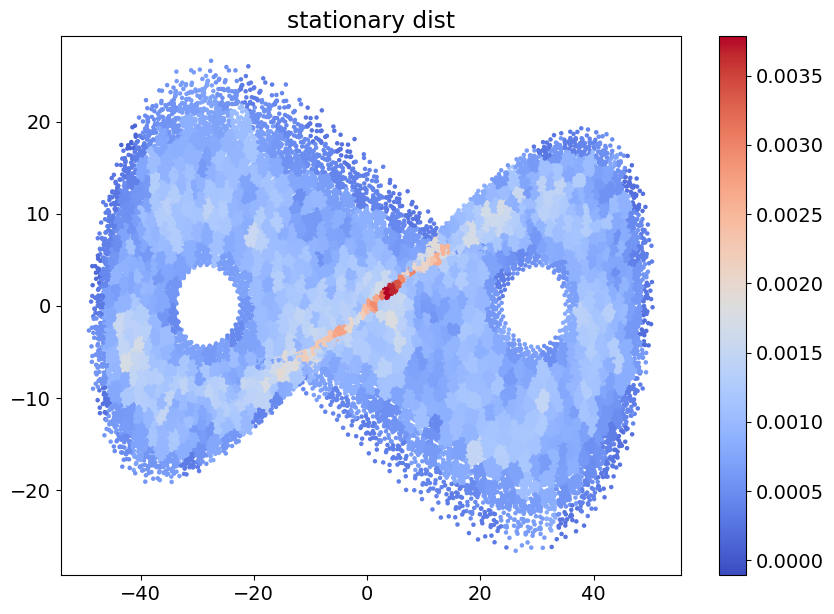

In [21]:
# visualize stationary distribution: 

mu = dtime.markov.tools.analysis.stationary_distribution(P_star)
mu_per_time_point = mu[labels_star]
plt.figure(figsize=(10, 7))
color_max = np.max(np.abs(mu))
color_min = np.min(np.abs(mu))
plt.scatter(traj_matrix_pca[:, 0], traj_matrix_pca[:, 1], c=mu_per_time_point,
            cmap='coolwarm', s=5,
            vmin=-color_min, vmax=color_max)
plt.title("stationary dist")
plt.colorbar()
plt.show()

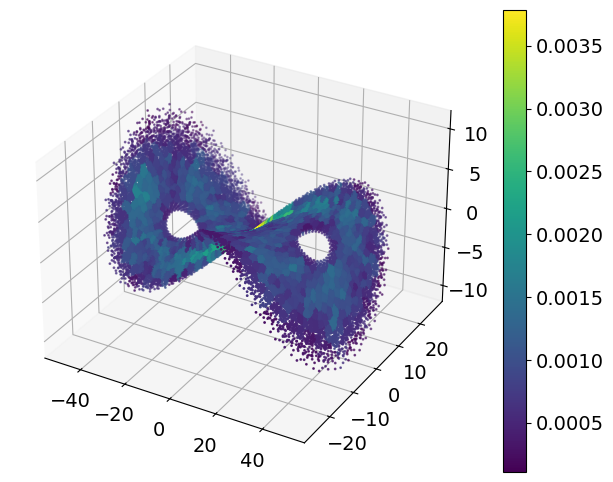

In [22]:
# 3D
# %matplotlib notebook
# %matplotlib
# plt.ioff()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
im = ax.scatter(xs=traj_matrix_pca[:, 0], ys=traj_matrix_pca[:, 1],
                zs=traj_matrix_pca[:, 2], c=mu_per_time_point, marker='o', s=1)
cbar = fig.colorbar(im, ax=ax)
plt.show()

# 5. Extra: Exploring deeptime

#### 5.1. Check countmatrix

In [23]:
# create some labels: 
delay = 5
n_clusters = 50

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="kmeans")

traj_matrix.shape=(99995, 6)


In [24]:
# count matrix: 
lags = [1, 100]
sliding_vals = [True, False]
for lag in lags:
    for sliding in sliding_vals:
        C = dtime.markov.tools.estimation.count_matrix(labels,
                                                       lag=lag,
                                                       sliding=sliding)

        connected = dtime.markov.tools.estimation.is_connected(C)
        connected_sets = dtime.markov.tools.estimation.connected_sets(C,
                                                                      directed=True)  # True is default. 
        print(f"{lag=}, {sliding=}: {connected=}, {len(connected_sets)=}")


lag=1, sliding=True: connected=True, len(connected_sets)=1
lag=1, sliding=False: connected=True, len(connected_sets)=1
lag=100, sliding=True: connected=True, len(connected_sets)=1
lag=100, sliding=False: connected=True, len(connected_sets)=1


#### 5.2 Check Transition matrix

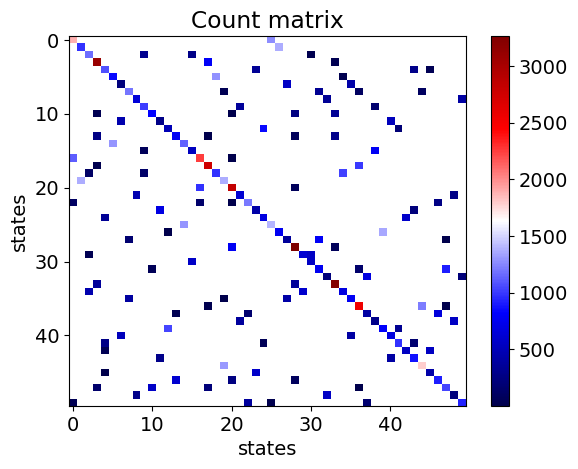

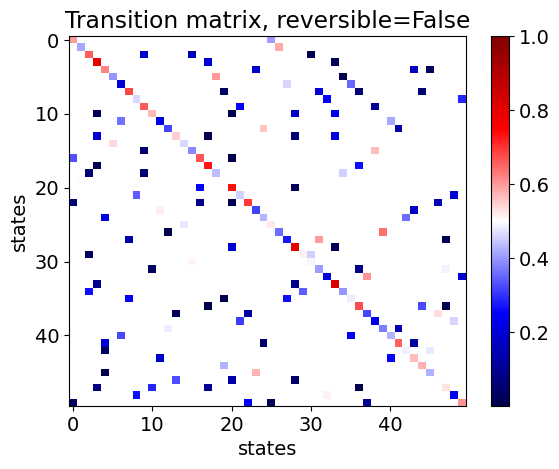

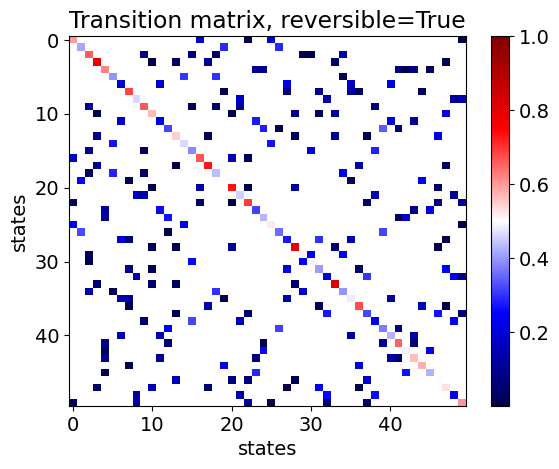

In [25]:
# Transition matrix:
lag = 1
sliding = True
reversible_vals = [False, True]
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=sliding)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(C.toarray(),
           cmap=cmap,
           interpolation='nearest',
           aspect='auto',
           vmin=0.0001,
           # vmax=1, 
           )
plt.colorbar()
plt.title(f"Count matrix")
plt.xlabel("states")
plt.ylabel("states")
plt.show()

for reversible in reversible_vals:
    P = dtime.markov.tools.estimation.transition_matrix(C, reversible=reversible)
    cmap = plt.get_cmap('seismic')  # You can choose any other colormap
    cmap.set_under('white')
    plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto',
               vmin=0.0001,
               vmax=1)
    plt.colorbar()
    plt.title(f"Transition matrix, {reversible=}")
    plt.xlabel("states")
    plt.ylabel("states")
    plt.show()

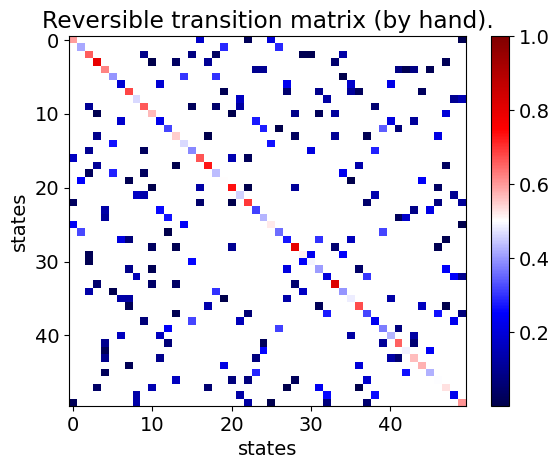

np.mean((R - P_dtime).toarray())=1.417529288394448e-18, np.std((R - P_dtime).toarray())=1.3580115544745721e-05


In [26]:
# reversible transition matrix by hand: 
lag = 1
sliding = True
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=sliding)
P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

mu = dtime.markov.tools.analysis.stationary_distribution(P)

P_hat = scipy.sparse.diags(1 / mu) * P.transpose() * scipy.sparse.diags(mu)
R = (P + P_hat) / 2

# plot
cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(R.toarray(), cmap=cmap, interpolation='nearest', aspect='auto',
           vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title(f"Reversible transition matrix (by hand).")
plt.xlabel("states")
plt.ylabel("states")
plt.show()

P_dtime = dtime.markov.tools.estimation.transition_matrix(C, reversible=True)
print(f"{np.mean((R - P_dtime).toarray())=}, {np.std((R - P_dtime).toarray())=}")

#### 5.3. Check time scales

In [27]:
# definition of time scales in AC code. 
from scipy.sparse.linalg import eigs
from scipy.linalg import eig


def compute_tscales(P, delay, dt=1, k=2):
    try:
        if P.shape[1] <= 10:
            eigvals = np.sort(eig(P.toarray())[0])[::-1][:k]
        else:
            eigvals = eigs(P, k=k, which='LR', return_eigenvectors=False)
        sorted_indices = np.argsort(eigvals.real)[::-1]
        eigvals = eigvals[sorted_indices][1:].real
        eigvals[np.abs(eigvals - 1) < 1e-12] = np.nan
        eigvals[eigvals < 1e-12] = np.nan
        return -(delay * dt) / np.log(np.abs(eigvals))
    except:
        return np.array([np.nan] * (k - 1))

traj_matrix.shape=(99989, 12)
len(delay_range)=19
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


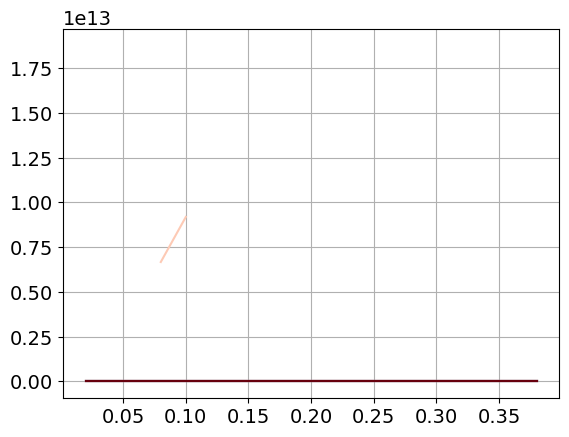

In [28]:
# create some labels: 
delay = 11
n_clusters = 1000

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="minibatchkmeans")

delay_range = np.arange(1, 20, 1)
print(f"{len(delay_range)=}")
n_modes = 5
ts_traj = np.zeros((len(delay_range), n_modes))
ts_traj_dtime = np.zeros((len(delay_range), n_modes))
for kd, delay in enumerate(delay_range):
    C = dtime.markov.tools.estimation.count_matrix(labels,
                                                   lag=delay,
                                                   sliding=True)
    R = dtime.markov.tools.estimation.transition_matrix(C, reversible=True)
    ts_traj[kd, :] = compute_tscales(R, delay, dt, k=n_modes + 1)
    ts_traj_dtime[kd, :]  = dtime.markov.tools.analysis.timescales(T=R,
                                                                   tau=delay * dt,
                                                                   k=n_modes,
                                                                   reversible=False)
    
    
    print(delay)

colors_modes = plt.cm.Blues_r(np.linspace(0.2, 1, n_modes))
color_modes_dtime = plt.cm.Reds(np.linspace(0.2, 1, n_modes))
for km in range(n_modes):
    plt.plot(delay_range * dt, ts_traj[:, km], c=colors_modes[km])
    plt.plot(delay_range * dt, ts_traj_dtime[:, km], c=color_modes_dtime[km])
plt.grid()
plt.show()

#### 5.4 Simulating reversible model

start_state_real_space.shape=(1, 12)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_real_space.shape=(1000, 12)


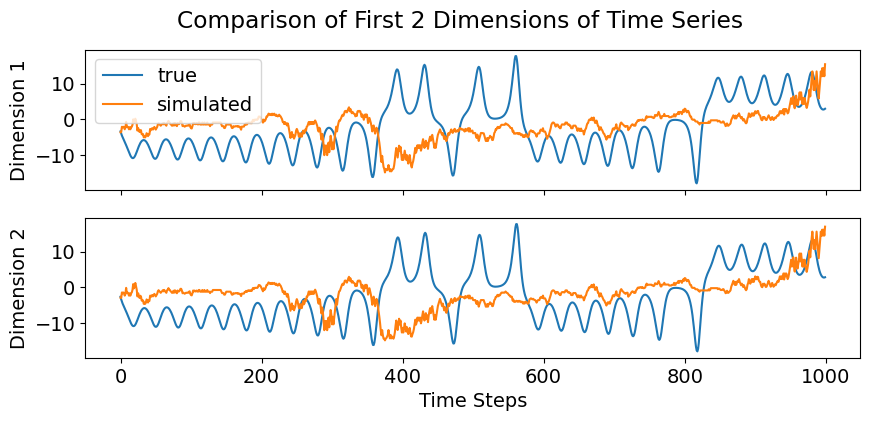

In [29]:
delay = 11
n_clusters = 1000

traj_matrix = time_delay_embedding(data=X, delay=delay)

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="kmeans")

C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=1,
                                               sliding=True)
R = dtime.markov.tools.estimation.transition_matrix(C, reversible=True)

msm = dtime.markov.msm.MarkovStateModel(R)
n_steps = 1000

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_real_space = centers[simulated_labels]
print(f"{simulated_real_space.shape=}")

# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_real_space[:time_window, :], k=2, label1="true",
                    label2="simulated")

# Other:

#### X.X Wild idea: (try to) calculate the largest lyapunov exponent using the transfer matrix: 

The idea is: 
- Start with two neighbouring descret states. Safe the initial distance between the centers (should be small). 
- Evolve them for some steps using the transition-matrix-simulator. You will arrive at two new states. 
- Safe the final distance between the centers of the new states. 
- Calculate the exponential rate of divergence between initial and final distance as a measure of the largest Lyapunov. 
⚠️ Does not really work. I believe because the initial distance between clusters is already too big. 

In [ ]:
from utils_dennis.lyap_from_trans_matrix import get_neighbour_label, \
    lle_from_transition_matrix

In [ ]:
# Testing the algorithm that gives you the neighbouring state to base_label, pointing roughly in the direction of prev_label. 
base_label = 0
prev_label = 1

neighbour_label, label_conv = get_neighbour_label(base_label, prev_label,
                                                  model=kmeans_model,
                                                  return_convergence=True)

print(neighbour_label, label_conv)

In [ ]:
# plot neighbour convergence: 

plt.plot(traj_matrix[:, 0], traj_matrix[:, 1], lw=.01)

base_center = centers[base_label]
prev_center = centers[prev_label]
plt.scatter(x=base_center[0], y=base_center[1], color="green", s=100)
plt.scatter(x=prev_center[0], y=prev_center[1], color="red", s=100)
for center_pnt in centers[label_conv]:
    plt.scatter(x=center_pnt[0], y=center_pnt[1], color="yellow", s=50)

plt.show()

In [ ]:
lle_conv = lle_from_transition_matrix(msm.simulate,
                                      kmeans_model,
                                      start_label_base=0,
                                      start_label_perturbed=1,
                                      steps=100,
                                      part_time_steps=3,
                                      steps_skip=10,
                                      return_convergence=True,
                                      dt=1
                                      )

In [ ]:
# Plot LLE conv: 
plt.plot(lle_conv)
plt.grid()
lle_conv[-1]